# Data Preprocessing
### import libraries

In [1]:
import sys, os
import numpy as np #only numpy arrays can be the input of keras
import pandas as pd
import matplotlib.pyplot as plt

### Train set

In [2]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')

#'training_set = dataset_train.iloc[:, 1].values' would only give us a 1D array
training_set = dataset_train.iloc[:, 1:2].values #gives us one column for open prices

### Feature scaling with Normalization: (X-min)/(max-min)

In [3]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set) # it is recommended to keep the original set separate

### Creating a data structure with n timesteps and 1 output

In [4]:
n_timesteps = 60 # number of timesteps

X_train = [] # will contain lists of previous stock prices
y_train = [] # will contain the next stock price


# start at 'n_timesteps' so that the first element actually has n previous prices
for i in range(n_timesteps, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-n_timesteps:i, 0]) # adds a list of n previous prices
    y_train.append(training_set_scaled[i, 0]) # adds the current price

X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping to add more indicators

In [5]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#for RNNs, the dimensions are (batch_size, timesteps, number of indicators). Here the only indicator is open price

# Building the RNN
### import libraries

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout # to prevent overfiting

### Initialising the RNN

In [7]:
regressor = Sequential() #the RNN
#Tip: A classifier predicts categories. A regressor predicts a continuous value.

### Adding the first LSTM layer and some Dropout regularisation

In [8]:
n_neurons = 50

regressor.add(LSTM( units = n_neurons, return_sequences= True, input_shape = (X_train.shape[1], 1)))
# units : neurons
# return_sequences: set to True if you are going to add more LSTM layers
#input_shape: only include the dimensions 'timesteps' and 'indicators' of X_train. The first dimension is already included

regressor.add(Dropout(.2))
#to prevent overfitting during regression, drop a part of the neurons during each iteration
#using a rate


### Adding more LSTM layers and Dropout regularizations

In [9]:
regressor.add(LSTM( units = n_neurons, return_sequences= True)) # we no longer need the input shape for following layers
regressor.add(Dropout(.2))

regressor.add(LSTM( units = n_neurons, return_sequences= True))
regressor.add(Dropout(.2))

regressor.add(LSTM( units = n_neurons, return_sequences= False)) #False because the next layer is not LSTM
regressor.add(Dropout(.2))


### Adding the output layer

In [10]:
regressor.add(Dense(units = 1))

### Compiling the RNN

In [11]:
regressor.compile(optimizer= 'adam', loss= 'mean_squared_error')

Fitting the RNN to the Training set

In [12]:
regressor.fit(X_train, y_train, epochs= 100, batch_size= 32)

Epoch 1/100
36/36 [==============================] - 4s 102ms/step - loss: 0.0394
Epoch 2/100
36/36 [==============================] - 3s 97ms/step - loss: 0.0060
Epoch 3/100
36/36 [==============================] - 3s 96ms/step - loss: 0.0055
Epoch 4/100
36/36 [==============================] - 3s 95ms/step - loss: 0.0057
Epoch 5/100
36/36 [==============================] - 3s 95ms/step - loss: 0.0054
Epoch 6/100
36/36 [==============================] - 3s 95ms/step - loss: 0.0048
Epoch 7/100
36/36 [==============================] - 3s 95ms/step - loss: 0.0048
Epoch 8/100
36/36 [==============================] - 3s 94ms/step - loss: 0.0043
Epoch 9/100
36/36 [==============================] - 3s 93ms/step - loss: 0.0049
Epoch 10/100
36/36 [==============================] - 3s 96ms/step - loss: 0.0049
Epoch 11/100
36/36 [==============================] - 3s 93ms/step - loss: 0.0042
Epoch 12/100
36/36 [==============================] - 3s 96ms/step - loss: 0.0042
Epoch 13/100
36/36 [====

# Making predictions and Visualising the results 

### Test set

In [13]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

### getting the predicted stock price

In [14]:
# On thing to point out is that we will need the previous stock prices of of the first items of the test set.
# Those previous prices must be obtained from the training set

# Also, we cannot change the test values. Therefore:
# we will concatonate the original dataframes for training and test set to obtain our missing values,
# and that's what we will scale.

dataset_total = pd.concat((dataset_train['Open'],dataset_test['Open']), axis = 0) #we are only keeping the 'Open column
# the second argument is the axis. We want to link the values in one column, so it's a vertical concatonation (0)

In [15]:
# Inputs: for each time T we're predicting, we need the n previous prices

#Here, we need n previous prices before the one we're predicting
# lower_bound = total index - total of the test set - n
lower_bound = len(dataset_total) - len(dataset_test) - n_timesteps

#Upper_bound is the last stock price before the last day, so simply the last item of dataset_total 
inputs = dataset_total[lower_bound:].values # add .values to make it a numpy array

#because we did not use 'iloc', we need to reshape the numpy array
inputs = inputs.reshape(-1,1)

#### reshape(-1,1) 
The criterion for the new shape is that it must be compatible with the original shape. **-1** means that the dimension is unknown and we are relying on the function to figure out the shape by itself

For example, **(-1,1)** means that the new shape must have one column and the number of rows is a dependent variable (rows = total / 1)

In [16]:
inputs = sc.transform(inputs) # scaling our inputs

X_test = []
for i in range(n_timesteps, inputs.shape[0]): # the range will be the 20 values we're trying to predict
    X_test.append(inputs[i-n_timesteps:i, 0])
X_test = np.array(X_test)

X_test = X_test.reshape( X_test.shape[0], X_test.shape[1], 1)

In [17]:
predicted_stock_price = regressor.predict(X_test) # predict the stock prices
predicted_stock_price = sc.inverse_transform(predicted_stock_price) # reverse the scaling to obtain the actual predicted prices

### Visualising the results

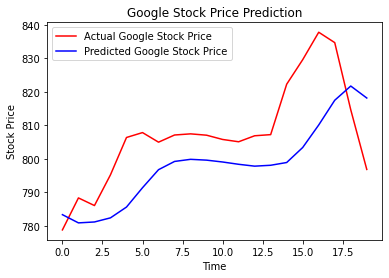

In [18]:
# adding data to the plot
plt.plot(real_stock_price, color = 'red', label = 'Actual Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')

plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend() # to display legends

plt.show()

### Evaluating the RNN
We can use the **Root Mean Squared Error (RMSE)** to check how close our predicted results are close to the actual prices. 
However, keep in mind that RMSE is not that most useful in this case since we're more concerned with the movements of the values instead.

In [19]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price,predicted_stock_price))

# dividing rmse by the average of values to get a relative error instead of absolute error
average_of_stock = (max(real_stock_price) + min(real_stock_price))/2
range_of_stock = max(real_stock_price)[0] - min(real_stock_price)[0]
relative_rmse = rmse/range_of_stock

print (f"RMSE: {rmse:5.2f}\nRelative RMSE: {relative_rmse:5.2f}")

RMSE: 14.61
Relative RMSE:  0.25
